In [3]:
# from nltk
from nltk.corpus import stopwords # Import the stop word list
import nltk
#from nltk.stem.porter import PorterStemmer  
from nltk.stem import WordNetLemmatizer # Lemmatization
 
# modules that are used
import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import os
import csv
import logging
import time
import random

from scipy.spatial.distance import cdist, pdist
from wordcloud import WordCloud
from langdetect import detect
from sklearn.externals import joblib

import string
from itertools import compress

import gensim
from gensim import corpora, models, similarities

import pyLDAvis.gensim

import plotly
plotly.offline.init_notebook_mode()
import plotly.plotly as py
import plotly.graph_objs as go

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.WARNING)

C:\Users\Domhoff\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [158]:
input_df = pd.read_table('TopicModeling.txt',delimiter="|",)

# There are some non-English abstracts in the data, thus do language detect and exclude (has some false positives)
def lang_detect(row):
    # don't run on empty abstracts, maybe rewrite to catch resulting exceptions
    return detect(row['abstract']) if (row['abstract'] == row['abstract'] and row['abstract'] != "" ) else ""

%time input_df['lang'] = input_df.apply(lang_detect, axis=1)
print(input_df.lang.value_counts())
input_df = input_df[input_df.lang == 'en']
# regenerate index to be consecutive again
input_df.index = range(len(input_df))

abstracts = input_df['abstract'].values.tolist()
titles = input_df['title'].values.tolist()
ids = input_df['id'].values.tolist()

print(str(len(abstracts)) + ' abstracts')
print(str(len(titles)) + ' titles')
print(str(len(ids)) + ' ids')

docs = (input_df.title.fillna('')+" "+input_df.abstract.fillna('')).tolist()

Wall time: 12min 23s
en    109598
fr       344
es        78
pt        50
ca        16
de         5
ro         4
fi         3
pl         3
           3
da         2
lt         1
nl         1
it         1
Name: lang, dtype: int64
109598 abstracts
109598 titles
109598 ids


In [167]:
%time tokenized = [nltk.word_tokenize(doc) for doc in docs]
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append("the")
tokenized = [[word.lower() for word in doc] for doc in tokenized]
# remove stopwords, words with 2 or less characters and words with other than chars, make lowercase
%time texts = [[word for word in doc if (word not in stopwords and len(word) > 2 and word.isalpha())] for doc in tokenized]

# generate collocation vocab
%time bi_phrases = gensim.models.Phrases(texts, min_count=100)
# Phraser should be faster than phrases method itself
phraser = gensim.models.phrases.Phraser(bi_phrases)
texts = list(phraser[texts])

# same for triple-collocation
%time tri_phrases = gensim.models.Phrases(texts, min_count=100)
phraser = gensim.models.phrases.Phraser(tri_phrases)
texts = list(phraser[texts])

# Lemmatize
lemma = WordNetLemmatizer()
texts = [[lemma.lemmatize(word) for word in text] for text in texts]

Wall time: 3min 5s


2018-04-17 18:34:01,450 : INFO : collecting all words and their counts
2018-04-17 18:34:01,451 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types


Wall time: 41.9 s


2018-04-17 18:34:03,455 : INFO : PROGRESS: at sentence #10000, processed 1195626 words and 734284 word types
2018-04-17 18:34:05,787 : INFO : PROGRESS: at sentence #20000, processed 2399162 words and 1298853 word types
2018-04-17 18:34:08,017 : INFO : PROGRESS: at sentence #30000, processed 3611162 words and 1791120 word types
2018-04-17 18:34:10,121 : INFO : PROGRESS: at sentence #40000, processed 4828300 words and 2239897 word types
2018-04-17 18:34:12,330 : INFO : PROGRESS: at sentence #50000, processed 6029121 words and 2646615 word types
2018-04-17 18:34:14,538 : INFO : PROGRESS: at sentence #60000, processed 7236379 words and 3036867 word types
2018-04-17 18:34:16,579 : INFO : PROGRESS: at sentence #70000, processed 8454498 words and 3411136 word types
2018-04-17 18:34:18,611 : INFO : PROGRESS: at sentence #80000, processed 9664290 words and 3763656 word types
2018-04-17 18:34:20,650 : INFO : PROGRESS: at sentence #90000, processed 10870343 words and 4109080 word types
2018-04-17

Wall time: 23.2 s


2018-04-17 18:35:12,321 : INFO : Phraser built with 1927 1927 phrasegrams
2018-04-17 18:35:45,027 : INFO : collecting all words and their counts
2018-04-17 18:35:45,027 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2018-04-17 18:35:46,903 : INFO : PROGRESS: at sentence #10000, processed 1129209 words and 764588 word types
2018-04-17 18:35:48,990 : INFO : PROGRESS: at sentence #20000, processed 2268145 words and 1367356 word types
2018-04-17 18:35:51,244 : INFO : PROGRESS: at sentence #30000, processed 3413674 words and 1899677 word types
2018-04-17 18:35:53,306 : INFO : PROGRESS: at sentence #40000, processed 4564586 words and 2388042 word types
2018-04-17 18:35:55,621 : INFO : PROGRESS: at sentence #50000, processed 5699494 words and 2833669 word types
2018-04-17 18:35:57,656 : INFO : PROGRESS: at sentence #60000, processed 6842085 words and 3261832 word types
2018-04-17 18:35:59,830 : INFO : PROGRESS: at sentence #70000, processed 7993991 words and 3673509 wor

Wall time: 22.8 s


2018-04-17 18:37:05,267 : INFO : Phraser built with 2726 2726 phrasegrams


In [171]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
print(dictionary)

# convert tokenized documents into a document-term matrix (bag-of-words)
corpus = [dictionary.doc2bow(text) for text in texts]

joblib.dump(input_df, 'data/input_df.pkl.gzip')
joblib.dump(dictionary, 'data/dictionary.pkl.gzip')
joblib.dump(texts, 'data/texts.pkl.gzip')
joblib.dump(corpus, 'data/corpus.pkl.gzip')

2018-04-17 18:40:27,942 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-04-17 18:40:29,173 : INFO : adding document #10000 to Dictionary(37547 unique tokens: ['advocacy', 'blindness', 'consumer', 'education', 'enables']...)
2018-04-17 18:40:30,234 : INFO : adding document #20000 to Dictionary(51338 unique tokens: ['advocacy', 'blindness', 'consumer', 'education', 'enables']...)
2018-04-17 18:40:31,364 : INFO : adding document #30000 to Dictionary(61639 unique tokens: ['advocacy', 'blindness', 'consumer', 'education', 'enables']...)
2018-04-17 18:40:32,437 : INFO : adding document #40000 to Dictionary(70992 unique tokens: ['advocacy', 'blindness', 'consumer', 'education', 'enables']...)
2018-04-17 18:40:33,527 : INFO : adding document #50000 to Dictionary(78307 unique tokens: ['advocacy', 'blindness', 'consumer', 'education', 'enables']...)
2018-04-17 18:40:34,637 : INFO : adding document #60000 to Dictionary(85871 unique tokens: ['advocacy', 'blindness', 'consumer',

Dictionary(117067 unique tokens: ['advocacy', 'blindness', 'consumer', 'education', 'enables']...)


['data/corpus.pkl.gzip']

In [4]:
input_df = joblib.load('data/input_df.pkl.gzip')
dictionary = joblib.load('data/dictionary.pkl.gzip')
texts = joblib.load('data/texts.pkl.gzip')
corpus = joblib.load('data/corpus.pkl.gzip')
print(len(corpus))

109598


In [ ]:
# 50%-sample from data for determination of metrics for faster results
sample_texts = random.sample(texts, int(len(texts)/2))
sample_dict = corpora.Dictionary(sample_texts)
sample_corpus = [sample_dict.doc2bow(text) for text in sample_texts]

# tmtoolkit needs document-term-matrix
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
dtm = mlb.fit_transform(sample_texts)

In [ ]:
# coherence metrics not yet available in public tmtoolkit ()
# see https://github.com/ddomhoff/tmtoolkit
from tmtoolkit.lda_utils import tm_gensim

def main():
    const_params = dict(chunksize=2000, passes=10, id2word=sample_dict, alpha="auto")
    # evaluate topic models with different parameters
    varying_params = [dict(num_topics=k) for k in range(4, 51, 2)]
    
    return tm_gensim.evaluate_topic_models(dtm, varying_params, const_params, return_models=True, texts=sample_texts)

if __name__ == '__main__':
    models = main()

# Model Evaluation Metrics 

**c_v coherence**: higher is better  
**cao juan**: less is better  
**perplexity** (loglikelihood): higher is better  
**u_mass coherence**: less is better

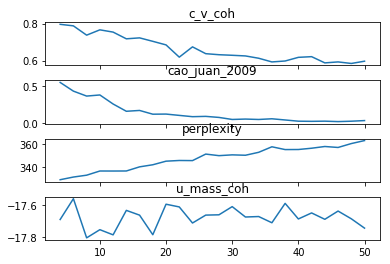

In [20]:
# Alternative to determine number of topics from
# https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html#Finding-out-the-optimal-number-of-topics

from tmtoolkit.lda_utils.common import results_by_parameter
from tmtoolkit.lda_utils.visualize import plot_eval_results

results_by_n_topics = results_by_parameter(models, 'num_topics')
plot_eval_results(results_by_n_topics)
plt.savefig('output/k=4-50.pdf')
plt.show()

In [8]:
num_topics = 35
np.random.seed(42)
# gensim can not determine alpha automatically in multicore method
#%time ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=25, id2word = dictionary, passes=3, alpha="auto")

ldamodel = gensim.models.ldamulticore.LdaMulticore(corpus, num_topics=num_topics, id2word = dictionary, passes=50)

In [6]:
joblib.dump(ldamodel, 'data/ldamodel.pkl.gzip')

['data/ldamodel.pkl.gzip']

In [5]:
ldamodel = joblib.load('data/ldamodel.pkl.gzip')

In [31]:
%time vis = pyLDAvis.gensim.prepare(ldamodel, corpus=corpus, dictionary=dictionary, R=30, lambda_step=0.1, sort_topics=False)
pyLDAvis.save_html(vis, "output/pyLDAvis_k=%s.html" % num_topics)
pyLDAvis.display(vis)

C:\Users\Domhoff\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


Wall time: 1min 50s


In [8]:
# write topics with key terms to file
with open('output/topics_terms.txt', 'w') as outfile:
    for i in range(0, ldamodel.num_topics):
        outfile.write(format('Topic #' + str(i+1) + ','))
        outfile.write(','.join([word for word, prob in ldamodel.show_topic(i, topn=10)]))
        outfile.write('\n')

In [6]:
# topic probabilities per document
topic_prob = pd.DataFrame([dict(doc) for doc in list(ldamodel.get_document_topics([doc for doc in corpus], minimum_probability=0.0))])
topic_prob.columns = topic_prob.columns+1
# create output dataset
out_df = pd.concat([input_df, topic_prob], axis=1)
# assign topic with highest probability
out_df['topic_no'] = topic_prob.idxmax(axis=1)
out_df.head()

# save to excel
writer = pd.ExcelWriter('output/docs_topics.xlsx', engine='xlsxwriter')
out_df.to_excel(writer)
writer.save()
out_df.head()

id author  year                                              title  \
0  117396    NaN   NaN                                The Lighthouse, Inc   
1  117401    NaN   NaN  CREATING A SUSTAINABLE PROJECT DASHBOARD (SU83...   
2  157885    NaN   NaN                               PHYSICIAN ENGAGEMENT   
3  157924    NaN   NaN  Technology Supports Care for Patients Demandin...   
4  159182    NaN   NaN                                       NOTICE BOARD   

                                            abstract lang         1         2  \
0  Lighthouse International: a leading worldwide ...   en  0.000840  0.000840   
1  SU833540br/bTitle:/b Creating a Sustainable Pr...   en  0.000146  0.021586   
2  The article discusses highlights of the June 2...   en  0.000772  0.000772   
3  The article reports on a pre-meeting program h...   en  0.000595  0.089516   
4  The article offers information on events relat...   en  0.000840  0.095398   

          3         4    ...           27        28        29        30  \
0  0.000840  0.000840    ...     0.082746  0.000840  0.000840  0.000840   
1  0.000146  0.306969    ...     0.000146  0.000146  0.000146  0.000146   
2  0.000772  0.000772    ...     0.000772  0.147053  0.000772  0.000772   
3  0.000595  0.000595    ...     0.000595  0.000595  0.000595  0.000595   
4  0.000840  0.000840    ...     0.000840  0.000840  0.201960  0.000840   

         31        32        33        34        35  topic_no  
0  0.070921  0.000840  0.173031  0.000840  0.000840        12  
1  0.000146  0.000146  0.142681  0.000146  0.000146         4  
2  0.000772  0.000772  0.000772  0.000772  0.000772        12  
3  0.000595  0.000595  0.259216  0.000595  0.000595        33  
4  0.000840  0.000840  0.000840  0.000840  0.000840        18  

[5 rows x 42 columns]

In [198]:
# should all have the same length
print(len(topic_prob))
print(len(out_df))
print(len(input_df))

109598
109598
109598


In [46]:
# export top 10 titles per topic
with open('output/top_documents.txt', 'w') as outfile:
    for t in range(1, num_topics+1):
        outfile.write(format('Topic #' + str(t) + '\n'))
        outfile.write("\n".join(out_df.sort_values(t, ascending=False).head(10)['title'].apply(str)))
        outfile.write('\n\n')

In [12]:
# frequencies of topics
topic_freq = pd.concat([pd.DataFrame(out_df.topic_no.value_counts(normalize=True, sort=False)),
                        pd.DataFrame(out_df.topic_no.value_counts(sort=False)),
                        pd.DataFrame([out_df[(out_df[i] > 0.2)].id.count() for i in range(1, num_topics +1)], index=range(1, num_topics+1))],
                       axis=1)
topic_freq.columns = ['freq', 'n', 'prob > 0.2']

# save to excel
writer = pd.ExcelWriter('output/topic_freq.xlsx', engine='xlsxwriter')
topic_freq.to_excel(writer)
writer.save()
topic_freq

freq      n  prob > 0.2
1   0.042692   4679        7609
2   0.023185   2541        4916
3   0.035147   3852        7251
4   0.066534   7292       12022
5   0.015584   1708        3279
6   0.001533    168         397
7   0.015739   1725        3389
8   0.025502   2795        4346
9   0.025959   2845        4186
10  0.019051   2088        3788
11  0.000931    102         162
12  0.119683  13117       19696
13  0.009261   1015        2083
14  0.037327   4091        6048
15  0.041908   4593        8262
16  0.005000    548         967
17  0.043194   4734        8182
18  0.019316   2117        3800
19  0.008413    922        1571
20  0.044517   4879        7896
21  0.030794   3375        5135
22  0.022738   2492        3975
23  0.007372    808        1570
24  0.014325   1570        2793
25  0.014562   1596        2790
26  0.002445    268         657
27  0.021323   2337        3939
28  0.025274   2770        4863
29  0.020995   2301        3773
30  0.030959   3393        6370
31  0.008805    965        1771
32  0.043723   4792        7146
33  0.042546   4663        7378
34  0.070713   7750       13721
35  0.042948   4707        8449

# Filter relevant documents by topic and repeat (subclustering)

In [13]:
# filter texts from selected topics from dataset
selected_topics = [33]
filter_texts = list(compress(texts, out_df[33] > 0.2))

# turn tokenized documents into a id <-> term dictionary
filter_dict = corpora.Dictionary(filter_texts)

# convert tokenized documents into a document-term matrix (bag-of-words)
filter_corpus = [filter_dict.doc2bow(text) for text in filter_texts]

In [16]:
num_topics_filter = 5
np.random.seed(43)
filtered_ldamodel = gensim.models.ldamulticore.LdaMulticore(filter_corpus, num_topics=num_topics_filter, id2word = filter_dict, passes=50)

In [84]:
%time vis = pyLDAvis.gensim.prepare(filtered_ldamodel, corpus=filter_corpus, dictionary=filter_dict, R=10, lambda_step=0.1, sort_topics=False)
pyLDAvis.save_html(vis, "output/pyLDAvis_selected_clusters.html")
pyLDAvis.display(vis)

C:\Users\Domhoff\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


Wall time: 14.9 s


In [17]:
# topic probabilities per document
topic_prob_filter = pd.DataFrame([dict(doc) for doc in list(filtered_ldamodel.get_document_topics([doc for doc in filter_corpus], minimum_probability=0.0))])
topic_prob_filter.columns = topic_prob_filter.columns+1

# create output dataset
selected_obs = out_df.loc[out_df[33] > 0.2]
selected_obs.index = range(len(selected_obs))
selected_obs = selected_obs.rename(columns={x: "old"+str(x) for x in range(1, num_topics+1)})
out_df_filter = pd.concat([selected_obs, topic_prob_filter], axis=1)

# assign topic with highest probability
out_df_filter['topic_no_filtered'] = topic_prob_filter.idxmax(axis=1)
out_df_filter.head()

# save to excel
writer = pd.ExcelWriter('output/docs_topics_filtered.xlsx', engine='xlsxwriter')
out_df_filter.to_excel(writer)
writer.save()
out_df.head()

id author  year                                              title  \
0  117396    NaN   NaN                                The Lighthouse, Inc   
1  117401    NaN   NaN  CREATING A SUSTAINABLE PROJECT DASHBOARD (SU83...   
2  157885    NaN   NaN                               PHYSICIAN ENGAGEMENT   
3  157924    NaN   NaN  Technology Supports Care for Patients Demandin...   
4  159182    NaN   NaN                                       NOTICE BOARD   

                                            abstract lang         1         2  \
0  Lighthouse International: a leading worldwide ...   en  0.000840  0.000840   
1  SU833540br/bTitle:/b Creating a Sustainable Pr...   en  0.000146  0.021586   
2  The article discusses highlights of the June 2...   en  0.000772  0.000772   
3  The article reports on a pre-meeting program h...   en  0.000595  0.089516   
4  The article offers information on events relat...   en  0.000840  0.095398   

          3         4    ...           27        28        29        30  \
0  0.000840  0.000840    ...     0.082746  0.000840  0.000840  0.000840   
1  0.000146  0.306969    ...     0.000146  0.000146  0.000146  0.000146   
2  0.000772  0.000772    ...     0.000772  0.147053  0.000772  0.000772   
3  0.000595  0.000595    ...     0.000595  0.000595  0.000595  0.000595   
4  0.000840  0.000840    ...     0.000840  0.000840  0.201960  0.000840   

         31        32        33        34        35  topic_no  
0  0.070921  0.000840  0.173031  0.000840  0.000840        12  
1  0.000146  0.000146  0.142681  0.000146  0.000146         4  
2  0.000772  0.000772  0.000772  0.000772  0.000772        12  
3  0.000595  0.000595  0.259216  0.000595  0.000595        33  
4  0.000840  0.000840  0.000840  0.000840  0.000840        18  

[5 rows x 42 columns]

In [18]:
# frequencies for subtopics
topic_freq_filter = pd.concat([pd.DataFrame(out_df_filter.topic_no_filtered.value_counts(normalize=True, sort=False)),
                               pd.DataFrame(out_df_filter.topic_no_filtered.value_counts(sort=False)),
                               pd.DataFrame([out_df_filter[(out_df_filter[i] > 0.2)].id.count() for i in range(1, num_topics_filter+1)], index=range(1, num_topics_filter+1))],
                              axis=1)
topic_freq_filter.columns = ['freq', 'n', 'prob > 0.2']

writer = pd.ExcelWriter('output/topic_freq_filter.xlsx', engine='xlsxwriter')
topic_freq_filter.to_excel(writer)
writer.save()
topic_freq_filter

freq     n  prob > 0.2
1  0.227840  1681        2758
2  0.130388   962        1907
3  0.188940  1394        2636
4  0.315533  2328        3580
5  0.137300  1013        2082

In [19]:
# print random sample of titles of subcluster
np.random.seed(10)
filter_title_sample = out_df_filter[out_df_filter['topic_no_filtered']==1].sample(10).loc[:, ['title','old26', 'old33', 1]]

writer = pd.ExcelWriter('output/title_sample_33-1.xlsx', engine='xlsxwriter')
filter_title_sample.to_excel(writer)
writer.save()
filter_title_sample

title     old26     old33  \
1886  Applications of Paper and Interactive Prototyp...  0.000203  0.648460   
1996  Distributed creative activity: Expanding Tikho...  0.000280  0.200729   
144    Negotiating boundaries: Managing disease at home  0.000381  0.268629   
6404  A room for design: Through participatory desig...  0.000246  0.276490   
1599  There are no secrets here!: Professional stake...  0.000298  0.215274   
931   Accessing care summaries at point-of-care:Impl...  0.000304  0.242888   
4264            Access Visits Using Video Communication  0.000714  0.499938   
1430  The limits of participatory technology develop...  0.026001  0.356553   
1689  Clinical forum: Assistive technology provision...  0.000493  0.202267   
4758  The place of surveillance technology in reside...  0.000136  0.274006   

             1  
1886  0.807383  
1996  0.427865  
144   0.623914  
6404  0.735452  
1599  0.825508  
931   0.991255  
4264  0.743934  
1430  0.848483  
1689  0.504730  
4758  0.819057

In [20]:
# topic correlations matrix
corr = out_df.loc[:, range(1, num_topics+1)].corr(method='spearman')

writer = pd.ExcelWriter('output/topic_correlations.xlsx', engine='xlsxwriter')
corr.to_excel(writer)
writer.save()
corr

1         2         3         4         5         6         7   \
1   1.000000  0.341105  0.107719  0.353718  0.337310  0.398285  0.386297   
2   0.341105  1.000000  0.072562  0.311166  0.360326  0.395808  0.372625   
3   0.107719  0.072562  1.000000 -0.040949  0.104225  0.244961  0.255474   
4   0.353718  0.311166 -0.040949  1.000000  0.339002  0.319014  0.233011   
5   0.337310  0.360326  0.104225  0.339002  1.000000  0.371777  0.280866   
6   0.398285  0.395808  0.244961  0.319014  0.371777  1.000000  0.439006   
7   0.386297  0.372625  0.255474  0.233011  0.280866  0.439006  1.000000   
8   0.323241  0.250715  0.321783  0.199046  0.340528  0.393515  0.329844   
9   0.359168  0.398981  0.307415  0.246079  0.286417  0.448638  0.513258   
10  0.255614  0.312020  0.164957  0.196930  0.243590  0.371198  0.316698   
11  0.503955  0.475799  0.248117  0.420291  0.489998  0.566304  0.495157   
12  0.121903  0.284835 -0.102105  0.197096  0.290455  0.258681  0.167511   
13  0.369903  0.356129  0.269154  0.242844  0.352869  0.433735  0.376666   
14  0.293158  0.429492  0.139708  0.285964  0.395405  0.381594  0.311983   
15  0.502980  0.381726  0.044659  0.420550  0.421403  0.386988  0.332905   
16  0.462710  0.449750  0.233409  0.365567  0.399412  0.516631  0.465540   
17  0.266875  0.285220  0.139974  0.290793  0.313163  0.361059  0.254910   
18  0.335865  0.406307  0.045718  0.344785  0.357239  0.392983  0.313959   
19  0.458527  0.394588  0.266119  0.342607  0.369386  0.490462  0.468097   
20  0.373469  0.270260  0.110056  0.356480  0.288284  0.327403  0.309060   
21  0.519951  0.393984  0.102610  0.452928  0.421990  0.451929  0.389411   
22  0.436015  0.384847  0.195738  0.334872  0.325909  0.464170  0.446973   
23  0.399538  0.432676  0.279374  0.309349  0.368025  0.488189  0.472972   
24  0.322973  0.358604  0.156307  0.254635  0.356831  0.405063  0.336287   
25  0.334288  0.370278  0.203592  0.236533  0.370008  0.415717  0.392010   
26  0.470513  0.437878  0.216603  0.395887  0.414420  0.510975  0.480416   
27  0.477852  0.360500  0.207954  0.345898  0.341504  0.426005  0.402235   
28  0.291703  0.292423  0.199031  0.239091  0.220344  0.390047  0.373400   
29  0.261597  0.303128  0.251370  0.231780  0.333462  0.392104  0.337309   
30  0.247409  0.349496 -0.011253  0.254136  0.322674  0.313815  0.268589   
31  0.421682  0.415407  0.279369  0.308639  0.381703  0.496783  0.462637   
32  0.496214  0.359705  0.131019  0.366206  0.320217  0.405796  0.396031   
33  0.428579  0.315390  0.149426  0.335444  0.391879  0.386514  0.327716   
34  0.206429  0.283815  0.034322  0.167980  0.194402  0.295300  0.345627   
35  0.132192  0.196996  0.127456  0.109355  0.296844  0.245953  0.158730   

          8         9         10    ...           26        27        28  \
1   0.323241  0.359168  0.255614    ...     0.470513  0.477852  0.291703   
2   0.250715  0.398981  0.312020    ...     0.437878  0.360500  0.292423   
3   0.321783  0.307415  0.164957    ...     0.216603  0.207954  0.199031   
4   0.199046  0.246079  0.196930    ...     0.395887  0.345898  0.239091   
5   0.340528  0.286417  0.243590    ...     0.414420  0.341504  0.220344   
6   0.393515  0.448638  0.371198    ...     0.510975  0.426005  0.390047   
7   0.329844  0.513258  0.316698    ...     0.480416  0.402235  0.373400   
8   1.000000  0.308062  0.268908    ...     0.374239  0.339385  0.256278   
9   0.308062  1.000000  0.342829    ...     0.531627  0.446894  0.355217   
10  0.268908  0.342829  1.000000    ...     0.365440  0.294365  0.267279   
11  0.479540  0.513800  0.405099    ...     0.626847  0.548547  0.389202   
12  0.196295  0.139205  0.262157    ...     0.247640  0.160521  0.190090   
13  0.431525  0.378260  0.293898    ...     0.441803  0.405953  0.291464   
14  0.305928  0.356467  0.267063    ...     0.438166  0.366726  0.304087   
15  0.323098  0.331821  0.283732    ...     0.467807  0.407511  0.271518   
16  0.373502  0.540707  0.374413    ...     0.594218  0.5